In [2]:
import random
from utils.snowflake_funcs import snowflake_connector  
from src.data_loaders.snowflake_utils import SnowflakeConnector
from src.experimentation.data_processors import ExperimentSummaryStats, ABDataProcessor, DFABTestProcessor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import math
from sklearn.feature_selection import SelectFromModel

## Load data and set random seed

In [3]:
random.seed(10)

In [ ]:
# load experiment 2660's data from the database by SQL 

In [6]:
# remove columns so that the data set can be userd for Model 3, Model 4, and Model 6
features = list(raw_cuped_df.columns)
features.remove('PRE_NUM_GAME_WON')
features.remove('CPI')
features.remove('SOURCE')
print(features)

['INSTALL_PK', 'VARIANT_NAME', 'VARIANT_DEFAULT', 'ASSIGNED_AT', 'NUM_GAME_START', 'TOTAL_REVENUE', 'NUM_AD_IMPRESSION_REWARDED', 'NUM_AD_IMPRESSION_INTERSTITIAL', 'NUM_AD_IMPRESSION_BANNER', 'PRE_NUM_GAME_START', 'PRE_TOTAL_REVENUE', 'PRE_NUM_AD_IMPRESSION_REWARDED', 'PRE_NUM_AD_IMPRESSION_INTERSTITIAL', 'PRE_NUM_AD_IMPRESSION_BANNER', 'INSTALL_DATE', 'COHORT_DAY_INSTALL', 'PLATFORM', 'COUNTRY_CODE', 'DEVICE_TYPE']


In [7]:
data = raw_cuped_df[features]

## Data preprocessing for Dataset1

In [ ]:
# label out who is active 14 days before
data.loc[data['PRE_NUM_GAME_START'].isna(), 'ACTIVE_PRE_14'] = 0
data.loc[data['ACTIVE_PRE_14']!=0, 'ACTIVE_PRE_14'] = 1

In [9]:
print('The proportion of having pre-experiment data:', data['ACTIVE_PRE_14'].sum()/data['ACTIVE_PRE_14'].count())

The proportion of having pre-experiment data: 0.017592980196425696


In [ ]:
# encode categorical variables
df_encoded = pd.get_dummies(data, columns=['PLATFORM', 'COUNTRY_CODE', 'DEVICE_TYPE'])
df_encoded.head()

## Model 4 (CUPED with ML) - handle missing values for new users' pre-experiment data

In [ ]:
# Split the data to train and test sets based on new or existin users
test = df_encoded.loc[df_encoded['PRE_NUM_GAME_START'].isna() , ]
train = df_encoded.loc[df_encoded['PRE_NUM_GAME_START'].notna(),]

In [19]:
train.isna().sum().sum()

0

In [20]:
# Select columns that are going to use in the machine learning model
features = list(df_encoded.columns)
features.remove('INSTALL_PK')
features.remove('VARIANT_NAME')
features.remove('VARIANT_DEFAULT')
features.remove('ASSIGNED_AT')
features.remove('INSTALL_DATE')
features.remove('ACTIVE_PRE_14')
features.remove('PRE_NUM_GAME_START')
features.remove('PRE_TOTAL_REVENUE')
features.remove('PRE_NUM_AD_IMPRESSION_REWARDED')
features.remove('PRE_NUM_AD_IMPRESSION_INTERSTITIAL')
features.remove('PRE_NUM_AD_IMPRESSION_BANNER')
print(features)

['NUM_GAME_START', 'TOTAL_REVENUE', 'NUM_AD_IMPRESSION_REWARDED', 'NUM_AD_IMPRESSION_INTERSTITIAL', 'NUM_AD_IMPRESSION_BANNER', 'COHORT_DAY_INSTALL', 'PLATFORM_android', 'PLATFORM_ios', 'COUNTRY_CODE_AD', 'COUNTRY_CODE_AE', 'COUNTRY_CODE_AF', 'COUNTRY_CODE_AG', 'COUNTRY_CODE_AI', 'COUNTRY_CODE_AL', 'COUNTRY_CODE_AM', 'COUNTRY_CODE_AO', 'COUNTRY_CODE_AR', 'COUNTRY_CODE_AS', 'COUNTRY_CODE_AT', 'COUNTRY_CODE_AU', 'COUNTRY_CODE_AW', 'COUNTRY_CODE_AX', 'COUNTRY_CODE_AZ', 'COUNTRY_CODE_BA', 'COUNTRY_CODE_BB', 'COUNTRY_CODE_BD', 'COUNTRY_CODE_BE', 'COUNTRY_CODE_BF', 'COUNTRY_CODE_BG', 'COUNTRY_CODE_BH', 'COUNTRY_CODE_BI', 'COUNTRY_CODE_BJ', 'COUNTRY_CODE_BM', 'COUNTRY_CODE_BN', 'COUNTRY_CODE_BO', 'COUNTRY_CODE_BQ', 'COUNTRY_CODE_BR', 'COUNTRY_CODE_BS', 'COUNTRY_CODE_BT', 'COUNTRY_CODE_BW', 'COUNTRY_CODE_BY', 'COUNTRY_CODE_BZ', 'COUNTRY_CODE_CA', 'COUNTRY_CODE_CD', 'COUNTRY_CODE_CG', 'COUNTRY_CODE_CH', 'COUNTRY_CODE_CI', 'COUNTRY_CODE_CK', 'COUNTRY_CODE_CL', 'COUNTRY_CODE_CM', 'COUNTRY_CODE_CN

In [21]:
# Build a XGBoost models to handle missing values
# X: five interested target metrics, cohort day, platform, country, device type, active pre 14 days
# Y: pre-experiment data of five target metrics
# the predictions are the estimated covariates

# We set the train and test sets as the entire dataset. Explanations are in the paper
target_variables = ['PRE_NUM_GAME_START', 'PRE_NUM_AD_IMPRESSION_BANNER', 'PRE_NUM_AD_IMPRESSION_INTERSTITIAL', 'PRE_NUM_AD_IMPRESSION_REWARDED', 'PRE_TOTAL_REVENUE']
X_train = train[features]
y_train = train[target_variables]
#y_train.dtypes  is object


y_train['PRE_TOTAL_REVENUE'] = pd.to_numeric(y_train.PRE_TOTAL_REVENUE, errors='coerce')
y_train.dtypes

/var/folders/vx/w5z5d3dd317gflztcs29ll8h0000gn/T/ipykernel_24839/3796772291.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['PRE_TOTAL_REVENUE'] = pd.to_numeric(y_train.PRE_TOTAL_REVENUE, errors='coerce')


PRE_NUM_GAME_START                    float64
PRE_NUM_AD_IMPRESSION_BANNER          float64
PRE_NUM_AD_IMPRESSION_INTERSTITIAL    float64
PRE_NUM_AD_IMPRESSION_REWARDED        float64
PRE_TOTAL_REVENUE                     float64
dtype: object

In [22]:
X_test = test[features]

model = xgb.XGBRegressor()
model.fit(X_train,y_train)
y_test = model.predict(X_test)
y_test

array([[ 1.78377800e+01,  1.86073748e-06, -1.38478383e-04,
         2.60462682e-03,  8.23827668e-06],
       [ 2.09245372e+00,  1.86073748e-06, -2.33595911e-03,
         1.03440927e-02,  8.23827668e-06],
       [ 7.84363127e+00,  4.37702965e-06,  2.34653309e-01,
        -1.14147095e-02,  2.19836020e-05],
       ...,
       [ 2.29284143e+00,  4.37702965e-06,  1.58369809e-01,
        -2.44796800e-04,  8.12034341e-05],
       [ 2.30325317e+00,  4.37702965e-06,  3.88843082e-02,
        -4.13784757e-03,  2.19836020e-05],
       [ 5.02682352e+00,  4.37702965e-06,  2.51611084e-01,
         1.46598238e-02,  2.24731066e-05]], dtype=float32)

In [ ]:
# update predicted pre-experiment data to the dataset
test['PRE_NUM_GAME_START'] = y_test[:,0]
test['PRE_NUM_AD_IMPRESSION_BANNER'] = y_test[:,1]
test['PRE_NUM_AD_IMPRESSION_INTERSTITIAL'] = y_test[:,2]
test['PRE_NUM_AD_IMPRESSION_REWARDED'] = y_test[:,3]
test['PRE_TOTAL_REVENUE'] = y_test[:,4]
test

In [ ]:
# Combine train and test datasets to get an entire dataset that includes all users and no missing values in pre-experiment data
frames = [train, test]
df_no_missing = pd.concat(frames)

## Model 6 (CUPAC with pre-experiment data) -  estimate covariates

In [26]:
cupac_data = data.copy()

In [ ]:
# fill the mising values in pre experimnet data with 0
cupac_data['PRE_NUM_GAME_START'] = cupac_data['PRE_NUM_GAME_START'].fillna(0)
cupac_data['PRE_TOTAL_REVENUE'] = cupac_data['PRE_TOTAL_REVENUE'].fillna(0)
cupac_data['PRE_NUM_AD_IMPRESSION_REWARDED'] = cupac_data['PRE_NUM_AD_IMPRESSION_REWARDED'].fillna(0)
cupac_data['PRE_NUM_AD_IMPRESSION_INTERSTITIAL'] = cupac_data['PRE_NUM_AD_IMPRESSION_INTERSTITIAL'].fillna(0)
cupac_data['PRE_NUM_AD_IMPRESSION_BANNER'] = cupac_data['PRE_NUM_AD_IMPRESSION_BANNER'].fillna(0)
cupac_data

In [ ]:
# encode categorical data
df_cupac_encoded = pd.get_dummies(cupac_data, columns=['PLATFORM', 'COUNTRY_CODE', 'DEVICE_TYPE'])

In [29]:
# Select variates that can provide information to estimate covariate
variates = list(df_cupac_encoded.columns)
variates.remove('INSTALL_PK')
variates.remove('NUM_GAME_START')
variates.remove('TOTAL_REVENUE')
variates.remove('INSTALL_DATE')
variates.remove('NUM_AD_IMPRESSION_REWARDED')
variates.remove('NUM_AD_IMPRESSION_INTERSTITIAL')
variates.remove('NUM_AD_IMPRESSION_BANNER')
variates.remove('ASSIGNED_AT')
variates.remove('VARIANT_NAME')
variates.remove('VARIANT_DEFAULT')
print(variates)

target_variables = ['NUM_GAME_START', 'TOTAL_REVENUE', 'NUM_AD_IMPRESSION_REWARDED', 'NUM_AD_IMPRESSION_INTERSTITIAL', 'NUM_AD_IMPRESSION_BANNER']


['PRE_NUM_GAME_START', 'PRE_TOTAL_REVENUE', 'PRE_NUM_AD_IMPRESSION_REWARDED', 'PRE_NUM_AD_IMPRESSION_INTERSTITIAL', 'PRE_NUM_AD_IMPRESSION_BANNER', 'COHORT_DAY_INSTALL', 'ACTIVE_PRE_14', 'PLATFORM_android', 'PLATFORM_ios', 'COUNTRY_CODE_AD', 'COUNTRY_CODE_AE', 'COUNTRY_CODE_AF', 'COUNTRY_CODE_AG', 'COUNTRY_CODE_AI', 'COUNTRY_CODE_AL', 'COUNTRY_CODE_AM', 'COUNTRY_CODE_AO', 'COUNTRY_CODE_AR', 'COUNTRY_CODE_AS', 'COUNTRY_CODE_AT', 'COUNTRY_CODE_AU', 'COUNTRY_CODE_AW', 'COUNTRY_CODE_AX', 'COUNTRY_CODE_AZ', 'COUNTRY_CODE_BA', 'COUNTRY_CODE_BB', 'COUNTRY_CODE_BD', 'COUNTRY_CODE_BE', 'COUNTRY_CODE_BF', 'COUNTRY_CODE_BG', 'COUNTRY_CODE_BH', 'COUNTRY_CODE_BI', 'COUNTRY_CODE_BJ', 'COUNTRY_CODE_BM', 'COUNTRY_CODE_BN', 'COUNTRY_CODE_BO', 'COUNTRY_CODE_BQ', 'COUNTRY_CODE_BR', 'COUNTRY_CODE_BS', 'COUNTRY_CODE_BT', 'COUNTRY_CODE_BW', 'COUNTRY_CODE_BY', 'COUNTRY_CODE_BZ', 'COUNTRY_CODE_CA', 'COUNTRY_CODE_CD', 'COUNTRY_CODE_CG', 'COUNTRY_CODE_CH', 'COUNTRY_CODE_CI', 'COUNTRY_CODE_CK', 'COUNTRY_CODE_CL'

In [30]:
# Build a XGBoost models to get covariates
# X: previous number of five interested target metrics, cohort day, platform, country, device type, new user
# Y: five interested target metrics
# the predictions are the estimated covariates

# We set the train and test sets as the entire dataset. Explanations are in the paper
X_train_covariate = df_cupac_encoded[variates]
X_test_covariate = df_cupac_encoded[variates]
X_train_covariate['PRE_TOTAL_REVENUE'] = pd.to_numeric(X_train_covariate.PRE_TOTAL_REVENUE, errors='coerce')
X_test_covariate['PRE_TOTAL_REVENUE'] = pd.to_numeric(X_test_covariate.PRE_TOTAL_REVENUE, errors='coerce')

y_train_covariate = df_cupac_encoded[target_variables]

model = xgb.XGBRegressor()
model.fit(X_train_covariate,y_train_covariate)

y_test_covariate = model.predict(X_test_covariate)
y_test_covariate

/var/folders/vx/w5z5d3dd317gflztcs29ll8h0000gn/T/ipykernel_24839/4033342147.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_covariate['PRE_TOTAL_REVENUE'] = pd.to_numeric(X_train_covariate.PRE_TOTAL_REVENUE, errors='coerce')
/var/folders/vx/w5z5d3dd317gflztcs29ll8h0000gn/T/ipykernel_24839/4033342147.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_covariate['PRE_TOTAL_REVENUE'] = pd.to_numeric(X_test_covariate.PRE_TOTAL_REVENUE, errors='coerce')


array([[-6.8156824e-02,  4.0406394e-03,  1.4929597e-01, -4.3587771e-01,
         2.0286480e-01],
       [ 2.0988593e+00,  1.7601267e-02, -5.8886325e-03,  4.4396710e-01,
         6.2768850e+00],
       [ 1.3120717e+01,  6.5233216e-02,  1.0811881e+00,  6.3050580e+00,
         3.2306343e-02],
       ...,
       [ 7.7642069e+00,  4.6465229e-02,  9.4534951e-01,  4.4618359e+00,
         1.2781999e-02],
       [ 7.4880681e+00,  3.3129588e-02,  7.4069279e-01,  4.1731215e+00,
         4.4979077e-02],
       [ 9.7991390e+00,  1.9175932e-02,  1.0562278e+00,  5.8222208e+00,
         2.1429179e-02]], dtype=float32)

In [31]:
cupac_final = df_cupac_encoded.copy()

In [ ]:
# add covariatest to the dataset
cupac_final['COV_NUM_GAME_START'] = y_test_covariate[:,0]
cupac_final['COV_TOTAL_REVENUE'] = y_test_covariate[:,1]
cupac_final['COV_NUM_AD_IMPRESSION_REWARDED'] = y_test_covariate[:,2]
cupac_final['COV_NUM_AD_IMPRESSION_INTERSTITIAL'] = y_test_covariate[:,3]
cupac_final['COV_NUM_AD_IMPRESSION_BANNER'] = y_test_covariate[:,4]
cupac_final

## Model 7 (CUPAC feature selected) -  get estimated covariates

In [ ]:
# use the data with all information
data_more = raw_cuped_df.copy()

In [ ]:
# data preprocessing
# encode categorical variables
df_cupac_more_encoded = pd.get_dummies(data_more, columns=['PLATFORM', 'COUNTRY_CODE', 'DEVICE_TYPE', 'SOURCE'])

# label inactive users
df_cupac_more_encoded.loc[df_cupac_more_encoded['PRE_NUM_GAME_START'].isna(), 'ACTIVE_PRE_14'] = 0
df_cupac_more_encoded.loc[df_cupac_more_encoded['ACTIVE_PRE_14']!=0, 'ACTIVE_PRE_14'] = 1

# fill missing values in pre-experiment data with 0
df_cupac_more_encoded['PRE_NUM_GAME_START'] = df_cupac_more_encoded['PRE_NUM_GAME_START'].fillna(0)
df_cupac_more_encoded['PRE_NUM_GAME_WON'] = df_cupac_more_encoded['PRE_NUM_GAME_WON'].fillna(0)
df_cupac_more_encoded['GAME_WIN_RATE'] = df_cupac_more_encoded['GAME_WIN_RATE'].fillna(0)
df_cupac_more_encoded['PRE_TOTAL_REVENUE'] = df_cupac_more_encoded['PRE_TOTAL_REVENUE'].fillna(0)
df_cupac_more_encoded['PRE_NUM_AD_IMPRESSION_REWARDED'] = df_cupac_more_encoded['PRE_NUM_AD_IMPRESSION_REWARDED'].fillna(0)
df_cupac_more_encoded['PRE_NUM_AD_IMPRESSION_INTERSTITIAL'] = df_cupac_more_encoded['PRE_NUM_AD_IMPRESSION_INTERSTITIAL'].fillna(0)
df_cupac_more_encoded['PRE_NUM_AD_IMPRESSION_BANNER'] = df_cupac_more_encoded['PRE_NUM_AD_IMPRESSION_BANNER'].fillna(0)

# calcuate game win rate
df_cupac_more_encoded['GAME_WIN_RATE'] = df_cupac_more_encoded['PRE_NUM_GAME_WON']/df_cupac_encoded['PRE_NUM_GAME_START']

df_cupac_more_encoded

In [36]:
# check missing values
df_cupac_more_encoded.isnull().sum().sum()

0

In [37]:
# transform data type of winng rate to ensure ML moddel run smoothly
df_cupac_more_encoded.loc[df_cupac_more_encoded['GAME_WIN_RATE'] ==math.inf, 'GAME_WIN_RATE'] = 0
df_cupac_more_encoded[df_cupac_more_encoded['GAME_WIN_RATE']==math.inf]

,INSTALL_PK,VARIANT_NAME,VARIANT_DEFAULT,ASSIGNED_AT,NUM_GAME_START,TOTAL_REVENUE,NUM_AD_IMPRESSION_REWARDED,NUM_AD_IMPRESSION_INTERSTITIAL,NUM_AD_IMPRESSION_BANNER,PRE_NUM_GAME_START,...,SOURCE_oppopaipreinstall_int,SOURCE_restricted,SOURCE_revenueuniverse_int,SOURCE_shalltry_int,SOURCE_tapjoy_int,SOURCE_thespotlight_int,SOURCE_tyrads_int,SOURCE_xiaomipai_int,ACTIVE_PRE_14,GAME_WIN_RATE


In [38]:
df_more_cleaned = df_cupac_more_encoded.copy()

In [39]:
# Select variates that can provide information to estimate covariate
variates = list(df_more_cleaned.columns)
variates.remove('INSTALL_PK')
variates.remove('TOTAL_REVENUE')
variates.remove('NUM_GAME_START')
variates.remove('PRE_NUM_GAME_WON')
variates.remove('INSTALL_DATE')
variates.remove('NUM_AD_IMPRESSION_REWARDED')
variates.remove('NUM_AD_IMPRESSION_INTERSTITIAL')
variates.remove('NUM_AD_IMPRESSION_BANNER')
variates.remove('ASSIGNED_AT')
variates.remove('VARIANT_NAME')
variates.remove('VARIANT_DEFAULT')

print(variates)


target_variables = ['NUM_GAME_START', 'TOTAL_REVENUE', 'NUM_AD_IMPRESSION_REWARDED', 'NUM_AD_IMPRESSION_INTERSTITIAL', 'NUM_AD_IMPRESSION_BANNER']

['PRE_NUM_GAME_START', 'PRE_TOTAL_REVENUE', 'PRE_NUM_AD_IMPRESSION_REWARDED', 'PRE_NUM_AD_IMPRESSION_INTERSTITIAL', 'PRE_NUM_AD_IMPRESSION_BANNER', 'COHORT_DAY_INSTALL', 'CPI', 'PLATFORM_android', 'PLATFORM_ios', 'COUNTRY_CODE_AD', 'COUNTRY_CODE_AE', 'COUNTRY_CODE_AF', 'COUNTRY_CODE_AG', 'COUNTRY_CODE_AI', 'COUNTRY_CODE_AL', 'COUNTRY_CODE_AM', 'COUNTRY_CODE_AO', 'COUNTRY_CODE_AR', 'COUNTRY_CODE_AS', 'COUNTRY_CODE_AT', 'COUNTRY_CODE_AU', 'COUNTRY_CODE_AW', 'COUNTRY_CODE_AX', 'COUNTRY_CODE_AZ', 'COUNTRY_CODE_BA', 'COUNTRY_CODE_BB', 'COUNTRY_CODE_BD', 'COUNTRY_CODE_BE', 'COUNTRY_CODE_BF', 'COUNTRY_CODE_BG', 'COUNTRY_CODE_BH', 'COUNTRY_CODE_BI', 'COUNTRY_CODE_BJ', 'COUNTRY_CODE_BM', 'COUNTRY_CODE_BN', 'COUNTRY_CODE_BO', 'COUNTRY_CODE_BQ', 'COUNTRY_CODE_BR', 'COUNTRY_CODE_BS', 'COUNTRY_CODE_BT', 'COUNTRY_CODE_BW', 'COUNTRY_CODE_BY', 'COUNTRY_CODE_BZ', 'COUNTRY_CODE_CA', 'COUNTRY_CODE_CD', 'COUNTRY_CODE_CG', 'COUNTRY_CODE_CH', 'COUNTRY_CODE_CI', 'COUNTRY_CODE_CK', 'COUNTRY_CODE_CL', 'COUNTRY

In [40]:
# Build a XGBoost models to get covariates
# X: previous number of five interested target metrics, cohort day, platform, country, device type, new user, CPI, source, game win rate
# Y: five interested target metrics
# the predictions are the estimated covariates

# We set the train and test sets as the entire dataset. Explanations are in the paper
X_train_covariate_more = df_more_cleaned[variates]
X_test_covariate_more = df_more_cleaned[variates]

X_train_covariate_more['PRE_TOTAL_REVENUE'] = pd.to_numeric(X_train_covariate_more.PRE_TOTAL_REVENUE, errors='coerce')
X_test_covariate_more['PRE_TOTAL_REVENUE'] = pd.to_numeric(X_test_covariate_more.PRE_TOTAL_REVENUE, errors='coerce')

y_train_covariate_more = df_more_cleaned[target_variables]

model = xgb.XGBRegressor()
model.fit(X_train_covariate_more,y_train_covariate_more)

/var/folders/vx/w5z5d3dd317gflztcs29ll8h0000gn/T/ipykernel_24839/2115043879.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_covariate_more['PRE_TOTAL_REVENUE'] = pd.to_numeric(X_train_covariate_more.PRE_TOTAL_REVENUE, errors='coerce')
/var/folders/vx/w5z5d3dd317gflztcs29ll8h0000gn/T/ipykernel_24839/2115043879.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_covariate_more['PRE_TOTAL_REVENUE'] = pd.to_numeric(X_test_covariate_more.PRE_TOTAL_REVENUE, errors='coerce')


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [41]:
# get the feature importance in the previous model
feature_importances = model.feature_importances_
feature_names = X_train_covariate_more.columns
# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Set pandas option to display all rows
pd.set_option('display.max_rows', None)
print(importance_df)

                                Feature    Importance
252                 SOURCE_kashkick_int  2.183428e-01
251             SOURCE_inboxdollars_int  1.945814e-01
248                    SOURCE_exmox_int  9.137344e-02
216                     COUNTRY_CODE_US  8.530607e-02
254                 SOURCE_mistplay_int  4.872309e-02
249                 SOURCE_freecash_int  4.213633e-02
233                   DEVICE_TYPE_phone  4.021525e-02
262                   SOURCE_tyrads_int  3.976364e-02
7                      PLATFORM_android  2.292567e-02
258          SOURCE_revenueuniverse_int  1.952506e-02
247           SOURCE_digitalturbine_int  1.664996e-02
261             SOURCE_thespotlight_int  1.535693e-02
243                 SOURCE_applovin_int  1.268640e-02
6                                   CPI  1.126248e-02
245                     SOURCE_aura_int  6.701243e-03
241                    SOURCE_adjoe_int  6.198665e-03
255                   SOURCE_moloco_int  4.602317e-03
244      SOURCE_appreciateap

In [42]:
# set the threshold to filter unimportant features
threshold = importance_df['Importance'].quantile(0.5)

In [43]:
# get selected features to retrain the model

# Initialize SelectFromModel with a threshold
selector = SelectFromModel(model, threshold=threshold, prefit=True)

# Transform the training and testing data
X_train_selected = selector.transform(X_train_covariate_more)
X_test_selected = selector.transform(X_test_covariate_more)

# Get the selected features
selected_features = X_train_covariate_more.columns[selector.get_support()]
print("Selected features:", selected_features)


/Users/poyu.wang/Documents/jess_project_repo/venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/poyu.wang/Documents/jess_project_repo/venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected features: Index(['PRE_NUM_GAME_START', 'PRE_NUM_AD_IMPRESSION_INTERSTITIAL',
       'PRE_NUM_AD_IMPRESSION_BANNER', 'COHORT_DAY_INSTALL', 'CPI',
       'PLATFORM_android', 'COUNTRY_CODE_AE', 'COUNTRY_CODE_AF',
       'COUNTRY_CODE_AG', 'COUNTRY_CODE_AR',
       ...
       'SOURCE_moloco_int', 'SOURCE_oppopaipreinstall_int',
       'SOURCE_restricted', 'SOURCE_revenueuniverse_int', 'SOURCE_tapjoy_int',
       'SOURCE_thespotlight_int', 'SOURCE_tyrads_int', 'SOURCE_xiaomipai_int',
       'ACTIVE_PRE_14', 'GAME_WIN_RATE'],
      dtype='object', length=133)


In [44]:
# Retrain the model with selected features
xgb_reg_selected = xgb.XGBRegressor()
xgb_reg_selected.fit(X_train_selected, y_train_covariate_more)
y_test_covariate_more = xgb_reg_selected.predict(X_test_selected)

In [46]:
# add covariatest to the dataset
df_more_result = df_more_cleaned.copy()
df_more_result['COV_NUM_GAME_START'] = y_test_covariate_more[:,0]
df_more_result['COV_TOTAL_REVENUE'] = y_test_covariate_more[:,1]
df_more_result['COV_NUM_AD_IMPRESSION_REWARDED'] = y_test_covariate_more[:,2]
df_more_result['COV_NUM_AD_IMPRESSION_INTERSTITIAL'] = y_test_covariate_more[:,3]
df_more_result['COV_NUM_AD_IMPRESSION_BANNER'] = y_test_covariate_more[:,4]

## CUPED adjustments

In [48]:
#CUPED adjustment for Model 4
def cuped_processer(df: pd.DataFrame, metrics: list[str]) -> pd.DataFrame:
    
    for metric in metrics:

        # Compute CUPED metric
        covariance = df["PRE_" + metric].cov(df[metric])
        pre_experiment_metric_variance = df["PRE_" + metric].var()
        theta = covariance / pre_experiment_metric_variance
        
        # Compute CUPED adjusted values
        df["CUPED_" + metric] = df[metric] - theta * (df["PRE_" + metric] - df["PRE_" + metric].mean())


    return df

In [49]:
metric_list = [
    "NUM_GAME_START", 
    "TOTAL_REVENUE", 
]

In [50]:
# calculate the CUPED adjusted number for model 4
variant_names = df_no_missing["VARIANT_NAME"].loc[df_no_missing["VARIANT_DEFAULT"] != 1].unique()
result_df_list = []

for variant in variant_names:
    # We perform cuped in pairs of variant and control
    # This is because to compute an unbiased stratified delta we need to compute the covariance from the pooled sample
    """
    From the paper:
    https://exp-platform.com/Documents/2013-02-CUPED-ImprovingSensitivityOfControlledExperiments.pdf

    "There is a slight subtlety that's worth pointing out. The
    pair (Y, X) may have different distributions in treatment
    and control when there is an experiment effect. For ∆cv
    to be unbiased, the same θ has to be used for both control
    and treatment. The simplest way to estimate it is from the
    pooled population of control and treatment. The impact on
    variance reduction will likely be negligible."
    """
    test_df = df_no_missing.loc[
        (df_no_missing["VARIANT_NAME"] == variant) | (df_no_missing["VARIANT_DEFAULT"] == 1),
        :
    ]

    test_df = cuped_processer(test_df, metric_list)

    ### Start Hypothesis Testing ###

    cuped_metrics = ["CUPED_" + metric for metric in metric_list]

    experiment_metrics = cuped_metrics + metric_list

    # Compute summary statistics
    experiment_summary_stats_transformer = ExperimentSummaryStats(
        test_df, experiment_metrics
    )
    raw_summary_df = experiment_summary_stats_transformer.transform()

    # Coerce dataframe to correct format
    df_test_processor = DFABTestProcessor(raw_summary_df)
    summary_df = df_test_processor.process_df()

    # Perform Z test
    ab_data_processor = ABDataProcessor(summary_df)
    ab_result = ab_data_processor.process_data()

    result_df_list.append(ab_result)

result_df = pd.concat(result_df_list)

In [ ]:
result_df["PERCENT_TREATMENT_UPLIFT"] = result_df["TREATMENT_UPLIFT"]*100

metric_inspect_list =  [
    "VARIANT_NAME",
    "KPI",
    "CONTROL_MEAN",
    "TREATMENT_MEAN",
    "P_VALUE",
    "UPLIFT_LOWER_CI",
    "PERCENT_TREATMENT_UPLIFT",
    "UPLIFT_UPPER_CI",
    "CONTROL_VARIANCE", 
    "TREATMENT_VARIANCE",
    "CONTROL_USERS",
    "TREATMENT_USERS",
]

display(result_df.loc[:, metric_inspect_list])


In [52]:
# CUPED adjustment function for CUPAC models
def cuped_processer_for_cupac(df: pd.DataFrame, metrics: list[str]) -> pd.DataFrame:
    
    for metric in metrics:

        # Compute CUPED metric
        covariance = df["COV_" + metric].cov(df[metric])
        covariate_variance = df["COV_" + metric].var()
        theta = covariance / covariate_variance
        
        # Compute CUPED adjusted values
        df["CUPAC_" + metric] = df[metric] - theta * (df["COV_" + metric] - df["COV_" + metric].mean())


    return df

In [53]:
# calculate the CUPED adjusted number for model 6
variant_names = cupac_final["VARIANT_NAME"].loc[cupac_final["VARIANT_DEFAULT"] != 1].unique()
result_df_list_cupac = []

for variant in variant_names:
    # We perform cuped in pairs of variant and control
    # This is because to compute an unbiased stratified delta we need to compute the covariance from the pooled sample
    test_df = cupac_final.loc[
        (cupac_final["VARIANT_NAME"] == variant) | (cupac_final["VARIANT_DEFAULT"] == 1),
        :
    ]

    test_df = cuped_processer_for_cupac(test_df, metric_list)

    ### Start Hypothesis Testing ###

    cuped_metrics = ["CUPAC_" + metric for metric in metric_list]

    experiment_metrics = cuped_metrics + metric_list

    # Compute summary statistics
    experiment_summary_stats_transformer = ExperimentSummaryStats(
        test_df, experiment_metrics
    )
    raw_summary_df = experiment_summary_stats_transformer.transform()

    # Coerce dataframe to correct format
    df_test_processor = DFABTestProcessor(raw_summary_df)
    summary_df = df_test_processor.process_df()

    # Perform Z test
    ab_data_processor = ABDataProcessor(summary_df)
    ab_result = ab_data_processor.process_data()

    result_df_list_cupac.append(ab_result)

result_df_cupac = pd.concat(result_df_list_cupac)

In [54]:
# calculate the CUPED adjusted number for model 7
variant_names = df_more_result["VARIANT_NAME"].loc[df_more_result["VARIANT_DEFAULT"] != 1].unique()
result_df_list_cupac_more = []

for variant in variant_names:
    # We perform cuped in pairs of variant and control
    # This is because to compute an unbiased stratified delta we need to compute the covariance from the pooled sample
    test_df = df_more_result.loc[
        (df_more_result["VARIANT_NAME"] == variant) | (df_more_result["VARIANT_DEFAULT"] == 1),
        :
    ]

    test_df = cuped_processer_for_cupac(test_df, metric_list)

    ### Start Hypothesis Testing ###

    cuped_metrics = ["CUPAC_" + metric for metric in metric_list]

    experiment_metrics = cuped_metrics + metric_list

    # Compute summary statistics
    experiment_summary_stats_transformer = ExperimentSummaryStats(
        test_df, experiment_metrics
    )
    raw_summary_df = experiment_summary_stats_transformer.transform()

    # Coerce dataframe to correct format
    df_test_processor = DFABTestProcessor(raw_summary_df)
    summary_df = df_test_processor.process_df()

    # Perform Z test
    ab_data_processor = ABDataProcessor(summary_df)
    ab_result = ab_data_processor.process_data()

    result_df_list_cupac_more.append(ab_result)

result_df_cupac_more = pd.concat(result_df_list_cupac_more)

In [57]:
# CUPED adjustment for Model 3
def cuped_processer_standard(df: pd.DataFrame, metrics: list[str]) -> pd.DataFrame:
    

    for metric in metrics:

        # Compute CUPED metric
        covariance = df["PRE_" + metric].cov(df[metric])
        pre_experiment_metric_variance = df["PRE_" + metric].var()
        theta = covariance / pre_experiment_metric_variance
        
        # Compute CUPED adjusted values
        df["CUPED_" + metric] = df[metric] - theta * (df["PRE_" + metric] - df["PRE_" + metric].mean())

        # Impute missing values with standard experiment values
        # This makes the assumption that we impute the pre experiment missing data with the mean value of the pre experiment data
        # Substituting this into the above equation sets the CUPED value to the standard experiment value
        df["CUPED_" + metric] = df["CUPED_" + metric].combine_first(df[metric])

    return df

In [58]:
metric_list = [
    "NUM_GAME_START", 
    "TOTAL_REVENUE", 
    "NUM_AD_IMPRESSION_REWARDED", 
    "NUM_AD_IMPRESSION_INTERSTITIAL",
    "NUM_AD_IMPRESSION_BANNER",
]
data['PRE_TOTAL_REVENUE'] = pd.to_numeric(y_train.PRE_TOTAL_REVENUE, errors='coerce')
variant_names = data["VARIANT_NAME"].loc[data["VARIANT_DEFAULT"] != 1].unique()
result_df_list_std = []

for variant in variant_names:
    # We perform cuped in pairs of variant and control
    # This is because to compute an unbiased stratified delta we need to compute the covariance from the pooled sample
    test_df = data.loc[
        (data["VARIANT_NAME"] == variant) | (data["VARIANT_DEFAULT"] == 1),
        :
    ]

    test_df = cuped_processer_standard(test_df, metric_list)

    ### Start Hypothesis Testing ###

    cuped_metrics = ["CUPED_" + metric for metric in metric_list]

    experiment_metrics = cuped_metrics + metric_list

    # Compute summary statistics
    experiment_summary_stats_transformer = ExperimentSummaryStats(
        test_df, experiment_metrics
    )
    raw_summary_df = experiment_summary_stats_transformer.transform()

    # Coerce dataframe to correct format
    df_test_processor = DFABTestProcessor(raw_summary_df)
    summary_df = df_test_processor.process_df()

    # Perform Z test
    ab_data_processor = ABDataProcessor(summary_df)
    ab_result = ab_data_processor.process_data()

    result_df_list_std.append(ab_result)

result_df_std = pd.concat(result_df_list_std)

/var/folders/vx/w5z5d3dd317gflztcs29ll8h0000gn/T/ipykernel_24839/149214388.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PRE_TOTAL_REVENUE'] = pd.to_numeric(y_train.PRE_TOTAL_REVENUE, errors='coerce')


## Results

In [59]:
treatment_name = 'Falling cards animation'

### 95% confidence intervals

In [60]:
# get the numbers of the control group
control_group = data.loc[data['VARIANT_DEFAULT']==1]
treatment = data.loc[data['VARIANT_NAME']== treatment_name]

In [61]:
# Calculate mean and standard error of the mean (SEM)
mean_control = control_group['NUM_GAME_START'].mean()
sem_control = stats.sem(control_group['NUM_GAME_START'])  # Standard error of the mean

# Calculate the 95% confidence interval
conf_int_control = stats.t.interval(
    0.95,                # Confidence level
    len(control_group['NUM_GAME_START'])-1,  # Degrees of freedom
    loc=mean_control,    # Mean
    scale=sem_control    # SEM
)

# Display the results
print('Control group without using tools')
print(f"Mean: {mean_control}")
print(f"95% Confidence Interval: {conf_int_control}")

mean_treatment = treatment['NUM_GAME_START'].mean()
sem_treatment = stats.sem(treatment['NUM_GAME_START'])  # Standard error of the mean

# Calculate the 95% confidence interval
conf_int_treatment = stats.t.interval(
    0.95,                # Confidence level
    len(treatment['NUM_GAME_START'])-1,  # Degrees of freedom
    loc=mean_treatment,    # Mean
    scale=sem_treatment    # SEM
)


# Display the results
print('\nVariant - Reward v2 without any tool')
print(f"Mean: {mean_treatment}")
print(f"95% Confidence Interval: {conf_int_treatment}")


Control group without using tools
Mean: 12.144485164110971
95% Confidence Interval: (12.00131201238097, 12.287658315840973)

Variant - Reward v2 without any tool
Mean: 12.079453601264394
95% Confidence Interval: (11.935947046872133, 12.222960155656654)


In [62]:
cuped_temp = data.loc[(data['VARIANT_NAME']==treatment_name) | (data['VARIANT_DEFAULT']==1)]
covariance = cuped_temp['PRE_NUM_GAME_START'].cov(cuped_temp['NUM_GAME_START'])
pre_exp_var = cuped_temp['PRE_NUM_GAME_START'].var()
theta = covariance/pre_exp_var

cuped_temp['CUPED_NUM_GAME_START'] = cuped_temp['NUM_GAME_START'] - theta * (cuped_temp['PRE_NUM_GAME_START'] - cuped_temp['PRE_NUM_GAME_START'].mean())
cuped_temp['CUPED_NUM_GAME_START'] = cuped_temp['CUPED_NUM_GAME_START'].combine_first(cuped_temp['NUM_GAME_START'])

control_group_cuped = cuped_temp.loc[cuped_temp['VARIANT_DEFAULT']==1]
treatment_cuped = cuped_temp.loc[cuped_temp['VARIANT_NAME']==treatment_name]

# Calculate mean and standard error of the mean (SEM)
mean_control_cuped = control_group_cuped['CUPED_NUM_GAME_START'].mean()
sem_control_cuped = stats.sem(control_group_cuped['CUPED_NUM_GAME_START'])  # Standard error of the mean

# Calculate the 95% confidence interval
conf_int_control_cuped = stats.t.interval(
    0.95,                # Confidence level
    len(control_group_cuped['CUPED_NUM_GAME_START'])-1,  # Degrees of freedom
    loc=mean_control_cuped,    # Mean
    scale=sem_control_cuped    # SEM
)

# Display the results
print('Control group with standard CUPED')
print(f"Mean: {mean_control_cuped}")
print(f"95% Confidence Interval: {conf_int_control_cuped}")

mean_treatment_cuped = treatment_cuped['CUPED_NUM_GAME_START'].mean()
sem_treatment_cuped = stats.sem(treatment_cuped['CUPED_NUM_GAME_START'])  # Standard error of the mean

# Calculate the 95% confidence interval
conf_int_treatment_cuped = stats.t.interval(
    0.95,                # Confidence level
    len(treatment_cuped['CUPED_NUM_GAME_START'])-1,  # Degrees of freedom
    loc=mean_treatment_cuped,    # Mean
    scale=sem_treatment_cuped    # SEM
)


# Display the results
print('\nVariant - Reward v2 with cuped')
print(f"Mean: {mean_treatment_cuped}")
print(f"95% Confidence Interval: {conf_int_treatment_cuped}")

Control group with standard CUPED
Mean: 12.145151623526568
95% Confidence Interval: (12.002092627807142, 12.288210619245993)

Variant - Reward v2 with cuped
Mean: 12.078784906201307
95% Confidence Interval: (11.93538758089984, 12.222182231502773)


In [63]:
cupedml_temp = df_no_missing.loc[(df_no_missing['VARIANT_NAME']==treatment_name) | (df_no_missing['VARIANT_DEFAULT']==1)]
covariance = cupedml_temp['PRE_NUM_GAME_START'].cov(cupedml_temp['NUM_GAME_START'])
pre_exp_var = cupedml_temp['PRE_NUM_GAME_START'].var()
theta = covariance/pre_exp_var

cupedml_temp['CUPED_NUM_GAME_START'] = cupedml_temp['NUM_GAME_START'] - theta * (cupedml_temp['PRE_NUM_GAME_START'] - cupedml_temp['PRE_NUM_GAME_START'].mean())


control_group_cupedml = cupedml_temp.loc[cupedml_temp['VARIANT_DEFAULT']==1]
treatment_cupedml = cupedml_temp.loc[cupedml_temp['VARIANT_NAME']==treatment_name]

# Calculate mean and standard error of the mean (SEM)
mean_control_cupedml = control_group_cupedml['CUPED_NUM_GAME_START'].mean()
sem_control_cupedml = stats.sem(control_group_cupedml['CUPED_NUM_GAME_START'])  # Standard error of the mean

# Calculate the 95% confidence interval
conf_int_control_cupedml = stats.t.interval(
    0.95,                # Confidence level
    len(control_group_cupedml['CUPED_NUM_GAME_START'])-1,  # Degrees of freedom
    loc=mean_control_cupedml,    # Mean
    scale=sem_control_cupedml    # SEM
)

# Display the results
print('Control group with CUPED_ML')
print(f"Mean: {mean_control_cupedml}")
print(f"95% Confidence Interval: {conf_int_control_cupedml}")

mean_treatment_cupedml = treatment_cupedml['CUPED_NUM_GAME_START'].mean()
sem_treatment_cupedml = stats.sem(treatment_cupedml['CUPED_NUM_GAME_START'])  # Standard error of the mean

# Calculate the 95% confidence interval
conf_int_treatment_cupedml = stats.t.interval(
    0.95,                # Confidence level
    len(treatment_cupedml['CUPED_NUM_GAME_START'])-1,  # Degrees of freedom
    loc=mean_treatment_cupedml,    # Mean
    scale=sem_treatment_cupedml    # SEM
)


# Display the results
print('\nVariant - reward v2 with cuped ml')
print(f"Mean: {mean_treatment_cupedml}")
print(f"95% Confidence Interval: {conf_int_treatment_cupedml}")

Control group with CUPED_ML
Mean: 12.133711479509119
95% Confidence Interval: (12.005095852038155, 12.262327106980083)

Variant - reward v2 with cuped ml
Mean: 12.090263426342933
95% Confidence Interval: (11.960596755722198, 12.219930096963667)


In [64]:
cupac_temp = cupac_final.loc[(cupac_final['VARIANT_NAME']==treatment_name) | (cupac_final['VARIANT_DEFAULT']==1)]
covariance = cupac_temp['COV_NUM_GAME_START'].cov(cupac_temp['NUM_GAME_START'])
pre_exp_var = cupac_temp['COV_NUM_GAME_START'].var()
theta = covariance/pre_exp_var

cupac_temp['CUPAC_NUM_GAME_START'] = cupac_temp['NUM_GAME_START'] - theta * (cupac_temp['COV_NUM_GAME_START'] - cupac_temp['COV_NUM_GAME_START'].mean())


control_group_cupac = cupac_temp.loc[cupac_temp['VARIANT_DEFAULT']==1]
treatment_cupac = cupac_temp.loc[cupac_temp['VARIANT_NAME']==treatment_name]

# Calculate mean and standard error of the mean (SEM)
mean_control_cupac = control_group_cupac['CUPAC_NUM_GAME_START'].mean()
sem_control_cupac = stats.sem(control_group_cupac['CUPAC_NUM_GAME_START'])  # Standard error of the mean

# Calculate the 95% confidence interval
conf_int_control_cupac = stats.t.interval(
    0.95,                # Confidence level
    len(control_group_cupac['CUPAC_NUM_GAME_START'])-1,  # Degrees of freedom
    loc=mean_control_cupac,    # Mean
    scale=sem_control_cupac    # SEM
)

# Display the results
print('Control group with CUPAC')
print(f"Mean: {mean_control_cupac}")
print(f"95% Confidence Interval: {conf_int_control_cupac}")

mean_treatment_cupac = treatment_cupac['CUPAC_NUM_GAME_START'].mean()
sem_treatment_cupac = stats.sem(treatment_cupac['CUPAC_NUM_GAME_START'])  # Standard error of the mean

# Calculate the 95% confidence interval
conf_int_treatment_cupac = stats.t.interval(
    0.95,                # Confidence level
    len(treatment_cupac['CUPAC_NUM_GAME_START'])-1,  # Degrees of freedom
    loc=mean_treatment_cupac,    # Mean
    scale=sem_treatment_cupac    # SEM
)


# Display the results
print('\nVariant - reward v2 with CUPAC')
print(f"Mean: {mean_treatment_cupac}")
print(f"95% Confidence Interval: {conf_int_treatment_cupac}")

Control group with CUPAC
Mean: 12.132028181246762
95% Confidence Interval: (11.992024244709164, 12.27203211778436)

Variant - reward v2 with CUPAC
Mean: 12.091950274699926
95% Confidence Interval: (11.951473767506204, 12.232426781893647)


In [65]:
cupac_more_temp = df_more_result.loc[(df_more_result['VARIANT_NAME']==treatment_name) | (df_more_result['VARIANT_DEFAULT']==1)]
covariance = cupac_more_temp['COV_NUM_GAME_START'].cov(cupac_more_temp['NUM_GAME_START'])
pre_exp_var = cupac_more_temp['COV_NUM_GAME_START'].var()
theta = covariance/pre_exp_var

cupac_more_temp['CUPAC_NUM_GAME_START'] = cupac_more_temp['NUM_GAME_START'] - theta * (cupac_more_temp['COV_NUM_GAME_START'] - cupac_more_temp['COV_NUM_GAME_START'].mean())


control_group_cupac_more = cupac_more_temp.loc[cupac_more_temp['VARIANT_DEFAULT']==1]
treatment_cupac_more = cupac_more_temp.loc[cupac_more_temp['VARIANT_NAME']==treatment_name]

# Calculate mean and standard error of the mean (SEM)
mean_control_cupac_more = control_group_cupac_more['CUPAC_NUM_GAME_START'].mean()
sem_control_cupac_more = stats.sem(control_group_cupac_more['CUPAC_NUM_GAME_START'])  # Standard error of the mean

# Calculate the 95% confidence interval
conf_int_control_cupac_more = stats.t.interval(
    0.95,                # Confidence level
    len(control_group_cupac_more['CUPAC_NUM_GAME_START'])-1,  # Degrees of freedom
    loc=mean_control_cupac_more,    # Mean
    scale=sem_control_cupac_more    # SEM
)

# Display the results
print('Control group with CUPAC feature selected')
print(f"Mean: {mean_control_cupac_more}")
print(f"95% Confidence Interval: {conf_int_control_cupac_more}")

mean_treatment_cupac_more = treatment_cupac_more['CUPAC_NUM_GAME_START'].mean()
sem_treatment_cupac_more = stats.sem(treatment_cupac_more['CUPAC_NUM_GAME_START'])  # Standard error of the mean

# Calculate the 95% confidence interval
conf_int_treatment_cupac_more = stats.t.interval(
    0.95,                # Confidence level
    len(treatment_cupac_more['CUPAC_NUM_GAME_START'])-1,  # Degrees of freedom
    loc=mean_treatment_cupac_more,    # Mean
    scale=sem_treatment_cupac_more    # SEM
)


# Display the results
print('\nVariant - reward v2 with CUPAC feature selected')
print(f"Mean: {mean_treatment_cupac_more}")
print(f"95% Confidence Interval: {conf_int_treatment_cupac_more}")

Control group with CUPAC feature selected
Mean: 12.123238103996028
95% Confidence Interval: (11.98766699668116, 12.258809211310897)

Variant - reward v2 with CUPAC feature selected
Mean: 12.100768705835682
95% Confidence Interval: (11.964707925091137, 12.236829486580227)


/var/folders/vx/w5z5d3dd317gflztcs29ll8h0000gn/T/ipykernel_24839/320357916.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(conf_int_treatment_cupac_more, ('Treatment - CUPAC feature selected', 'Treatment - CUPAC feature selected'), 'o-', color='gray', marker='o', markersize=6, linewidth=2)
/var/folders/vx/w5z5d3dd317gflztcs29ll8h0000gn/T/ipykernel_24839/320357916.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(conf_int_control_cupac_more, ('Control - CUPAC feature selected', 'Control - CUPAC feature selected'), 'o-', color='black', marker='o', markersize=6, linewidth=2)
/var/folders/vx/w5z5d3dd317gflztcs29ll8h0000gn/T/ipykernel_24839/320357916.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the 

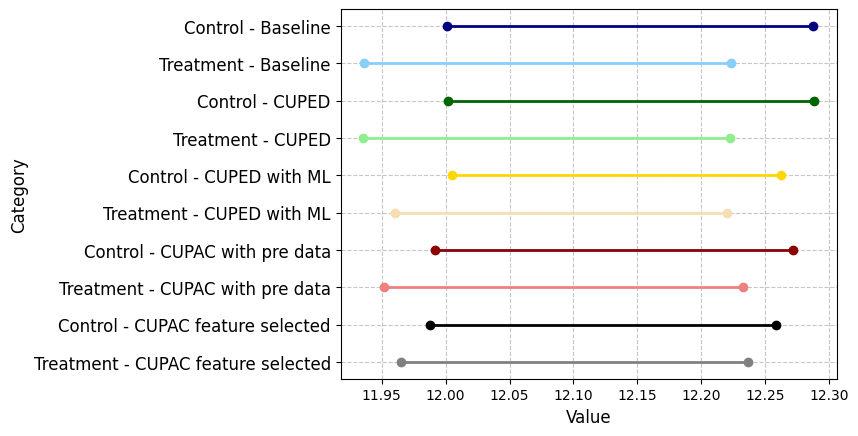

In [73]:
# Plot the confidence intervals

category = ['Treatment - CUPAC feature selected', 'Control - CUPAC feature selected', 'Treatment - CUPAC with pre data', 'Control - CUPAC with pre data', 'Treatment - CUPED with ML', 'Control - CUPED with ML', 'Treatment - CUPED', 'Control - CUPED', 'Treatment - Baseline', 'Control - Baseline']


plt.plot(conf_int_treatment_cupac_more, ('Treatment - CUPAC feature selected', 'Treatment - CUPAC feature selected'), 'o-', color='gray', marker='o', markersize=6, linewidth=2)
plt.plot(conf_int_control_cupac_more, ('Control - CUPAC feature selected', 'Control - CUPAC feature selected'), 'o-', color='black', marker='o', markersize=6, linewidth=2)
plt.plot(conf_int_treatment_cupac, ('Treatment - CUPAC with pre data', 'Treatment - CUPAC with pre data'), 'o-', color='lightcoral', marker='o', markersize=6, linewidth=2)
plt.plot(conf_int_control_cupac, ('Control - CUPAC with pre data', 'Control - CUPAC with pre data'), 'o-', color='darkred', marker='o', markersize=6, linewidth=2)
plt.plot(conf_int_treatment_cupedml, ('Treatment - CUPED with ML', 'Treatment - CUPED with ML'), 'o-', color='wheat', marker='o', markersize=6, linewidth=2)
plt.plot(conf_int_control_cupedml, ('Control - CUPED with ML', 'Control - CUPED with ML'), 'o-', color='gold', marker='o', markersize=6, linewidth=2)
plt.plot(conf_int_treatment_cuped, ('Treatment - CUPED', 'Treatment - CUPED'), 'o-', color='lightgreen', marker='o', markersize=6, linewidth=2)
plt.plot(conf_int_control_cuped, ('Control - CUPED', 'Control - CUPED'), 'o-', color='darkgreen', marker='o', markersize=6, linewidth=2)
plt.plot(conf_int_treatment, ('Treatment - Baseline', 'Treatment - Baseline'), 'o-', color='lightskyblue', marker='o', markersize=6, linewidth=2)
plt.plot(conf_int_control, ('Control - Baseline', 'Control - Baseline'), 'o-', color='navy', marker='o', markersize=6, linewidth=2)




# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Add title and labels
# plt.title('95% Confidence absolute values - number of game start')
plt.xlabel('Value', fontsize=12)
plt.ylabel('Category', fontsize=12)

# Customize y-ticks
plt.yticks(range(len(category)), category, fontsize=12)

# Add a vertical line at zero if needed
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

# Show the plot
plt.show()

### 95% CI uplift

In [74]:
ci_uplift_lower_num_game_start=[]
ci_uplift_upper_num_game_start=[]

ci_uplift_lower_num_game_start.append(result_df_cupac_more.loc[(result_df_cupac_more['VARIANT_NAME']==treatment_name) & (result_df_cupac_more['KPI']=='CUPAC_NUM_GAME_START'), 'UPLIFT_LOWER_CI'])
ci_uplift_lower_num_game_start.append(result_df_cupac.loc[(result_df_cupac['VARIANT_NAME']==treatment_name) & (result_df_cupac['KPI']=='CUPAC_NUM_GAME_START'), 'UPLIFT_LOWER_CI'])
ci_uplift_lower_num_game_start.append(result_df.loc[(result_df['VARIANT_NAME']==treatment_name) & (result_df['KPI']=='CUPED_NUM_GAME_START'), 'UPLIFT_LOWER_CI'])
ci_uplift_lower_num_game_start.append(result_df_std.loc[(result_df_std['VARIANT_NAME']==treatment_name) & (result_df_std['KPI']=='CUPED_NUM_GAME_START'), 'UPLIFT_LOWER_CI'])
ci_uplift_lower_num_game_start.append(result_df.loc[(result_df['VARIANT_NAME']==treatment_name) & (result_df['KPI']=='NUM_GAME_START'), 'UPLIFT_LOWER_CI'])

ci_uplift_upper_num_game_start.append(result_df_cupac_more.loc[(result_df_cupac_more['VARIANT_NAME']==treatment_name) & (result_df_cupac_more['KPI']=='CUPAC_NUM_GAME_START'), 'UPLIFT_UPPER_CI'])
ci_uplift_upper_num_game_start.append(result_df_cupac.loc[(result_df_cupac['VARIANT_NAME']==treatment_name) & (result_df_cupac['KPI']=='CUPAC_NUM_GAME_START'), 'UPLIFT_UPPER_CI'])
ci_uplift_upper_num_game_start.append(result_df.loc[(result_df['VARIANT_NAME']==treatment_name) & (result_df['KPI']=='CUPED_NUM_GAME_START'), 'UPLIFT_UPPER_CI'])
ci_uplift_upper_num_game_start.append(result_df_std.loc[(result_df_std['VARIANT_NAME']==treatment_name) & (result_df_std['KPI']=='CUPED_NUM_GAME_START'), 'UPLIFT_UPPER_CI'])
ci_uplift_upper_num_game_start.append(result_df.loc[(result_df['VARIANT_NAME']==treatment_name) & (result_df['KPI']=='NUM_GAME_START'), 'UPLIFT_UPPER_CI'])

# category = ['CUPED', 'CUPED with ML', 'CUPAC with pre data', 'CUPAC feature selected', 'Baseline']
category = ['CUPAC feature selected', 'CUPAC with pre data', 'CUPED with ML', 'CUPED', 'Baseline']
ci_uplift_upper_num_game_start


[0    0.0114
 Name: UPLIFT_UPPER_CI, dtype: float64,
 0    0.0104
 Name: UPLIFT_UPPER_CI, dtype: float64,
 0    0.0091
 Name: UPLIFT_UPPER_CI, dtype: float64,
 3    0.0085
 Name: UPLIFT_UPPER_CI, dtype: float64,
 2    0.0087
 Name: UPLIFT_UPPER_CI, dtype: float64]

/var/folders/vx/w5z5d3dd317gflztcs29ll8h0000gn/T/ipykernel_24839/1948458969.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot((lower, upper), (y, y), 'ro-', color='orange', marker='o', markersize=6, linewidth=2)
/var/folders/vx/w5z5d3dd317gflztcs29ll8h0000gn/T/ipykernel_24839/1948458969.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot((lower, upper), (y, y), 'ro-', color='orange', marker='o', markersize=6, linewidth=2)


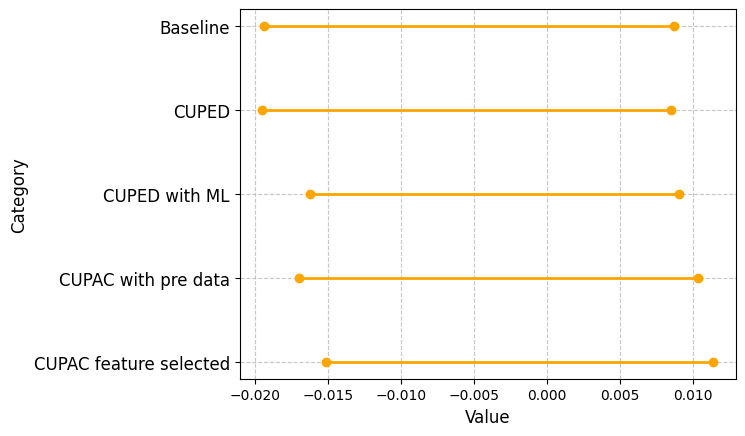

In [76]:
# Plot the confidence intervals
for lower, upper, y in zip(ci_uplift_lower_num_game_start, ci_uplift_upper_num_game_start, range(len(category))):
    plt.plot((lower, upper), (y, y), 'ro-', color='orange', marker='o', markersize=6, linewidth=2)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Add title and labels
# plt.title('95% Confidence Intervals Uplift for Different Tools')
plt.xlabel('Value', fontsize=12)
plt.ylabel('Category', fontsize=12)

# Customize y-ticks
plt.yticks(range(len(category)), category, fontsize=12)

# Add a vertical line at zero if needed
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

# Show the plot
plt.show()

### Summary table

In [72]:
print('Table of expermiment results for the variant 1.0 Coefficient, Game Start')
game_start_result = {
    'Withouht variance reduction tools': result_df.loc[(result_df['VARIANT_NAME']==treatment_name) & (result_df['KPI']=='NUM_GAME_START'),'P_VALUE'].values[0],
    'CUPED standard': result_df_std.loc[(result_df_std['VARIANT_NAME']==treatment_name) & (result_df_std['KPI']=='CUPED_NUM_GAME_START'),'P_VALUE'].values[0],
    'CUPED with ML': result_df.loc[(result_df['VARIANT_NAME']==treatment_name) & (result_df['KPI']=='CUPED_NUM_GAME_START'),'P_VALUE'].values[0],
    'CUPAC': result_df_cupac.loc[(result_df_cupac['VARIANT_NAME']==treatment_name) & (result_df_cupac['KPI']=='CUPAC_NUM_GAME_START'),'P_VALUE'].values[0],
    'CUPAC feature selected': result_df_cupac_more.loc[(result_df_cupac_more['VARIANT_NAME']==treatment_name) & (result_df_cupac_more['KPI']=='CUPAC_NUM_GAME_START'),'P_VALUE'].values[0]
}
game_start_result_df = pd.DataFrame(list(game_start_result.items()), columns=['Model', 'P-value'])
pd.set_option('display.precision', 11)

variance = {
    'Withouht variance reduction tools': result_df.loc[(result_df['VARIANT_NAME']==treatment_name) & (result_df['KPI']=='NUM_GAME_START'),'TREATMENT_VARIANCE'].values[0],
    'CUPED standard': result_df_std.loc[(result_df_std['VARIANT_NAME']==treatment_name) & (result_df_std['KPI']=='CUPED_NUM_GAME_START'),'TREATMENT_VARIANCE'].values[0],
    'CUPED with ML': result_df.loc[(result_df['VARIANT_NAME']==treatment_name) & (result_df['KPI']=='CUPED_NUM_GAME_START'),'TREATMENT_VARIANCE'].values[0],
    'CUPAC': result_df_cupac.loc[(result_df_cupac['VARIANT_NAME']==treatment_name) & (result_df_cupac['KPI']=='CUPAC_NUM_GAME_START'),'TREATMENT_VARIANCE'].values[0],
    'CUPAC feature selected': result_df_cupac_more.loc[(result_df_cupac_more['VARIANT_NAME']==treatment_name) & (result_df_cupac_more['KPI']=='CUPAC_NUM_GAME_START'),'TREATMENT_VARIANCE'].values[0]
}
game_start_result_df['Variance'] = game_start_result_df['Model'].map(variance)

percentage_list=[]
for i in range(5):
    percentage_list.append(((game_start_result_df['Variance'][0] - game_start_result_df['Variance'][i])/game_start_result_df['Variance'][0])*100)

game_start_result_df['Variance Reduction (%)'] = percentage_list



treatment_mean = {
    'Withouht variance reduction tools': result_df.loc[(result_df['VARIANT_NAME']==treatment_name) & (result_df['KPI']=='NUM_GAME_START'),'TREATMENT_MEAN'].values[0],
    'CUPED standard': result_df_std.loc[(result_df_std['VARIANT_NAME']==treatment_name) & (result_df_std['KPI']=='CUPED_NUM_GAME_START'),'TREATMENT_MEAN'].values[0],
    'CUPED with ML': result_df.loc[(result_df['VARIANT_NAME']==treatment_name) & (result_df['KPI']=='CUPED_NUM_GAME_START'),'TREATMENT_MEAN'].values[0],
    'CUPAC': result_df_cupac.loc[(result_df_cupac['VARIANT_NAME']==treatment_name) & (result_df_cupac['KPI']=='CUPAC_NUM_GAME_START'),'TREATMENT_MEAN'].values[0],
    'CUPAC feature selected': result_df_cupac_more.loc[(result_df_cupac_more['VARIANT_NAME']==treatment_name) & (result_df_cupac_more['KPI']=='CUPAC_NUM_GAME_START'),'TREATMENT_MEAN'].values[0]
}
game_start_result_df['Tr_mean'] = game_start_result_df['Model'].map(treatment_mean)

control_mean = {
    'Withouht variance reduction tools': result_df.loc[(result_df['VARIANT_NAME']==treatment_name) & (result_df['KPI']=='NUM_GAME_START'),'CONTROL_MEAN'].values[0],
    'CUPED standard': result_df_std.loc[(result_df_std['VARIANT_NAME']==treatment_name) & (result_df_std['KPI']=='CUPED_NUM_GAME_START'),'CONTROL_MEAN'].values[0],
    'CUPED with ML': result_df.loc[(result_df['VARIANT_NAME']==treatment_name) & (result_df['KPI']=='CUPED_NUM_GAME_START'),'CONTROL_MEAN'].values[0],
    'CUPAC': result_df_cupac.loc[(result_df_cupac['VARIANT_NAME']==treatment_name) & (result_df_cupac['KPI']=='CUPAC_NUM_GAME_START'),'CONTROL_MEAN'].values[0],
    'CUPAC feature selected': result_df_cupac_more.loc[(result_df_cupac_more['VARIANT_NAME']==treatment_name) & (result_df_cupac_more['KPI']=='CUPAC_NUM_GAME_START'),'CONTROL_MEAN'].values[0]
}
game_start_result_df['Co_mean'] = game_start_result_df['Model'].map(control_mean)

game_start_result_df['Effect size'] = game_start_result_df['Tr_mean']-game_start_result_df['Co_mean']


display(game_start_result_df)

Table of expermiment results for the variant 1.0 Coefficient, Game Start


,Model,P-value,Variance,Variance Reduction (%),Tr_mean,Co_mean,Effect size
0,Withouht variance reduction tools,0.73525013867,1662.06353540943,0.00000000000,12.07945360126,12.14448516411,-0.06503156285
1,CUPED standard,0.73962166361,1659.53436037041,0.15217077958,12.07878490620,12.14515162353,-0.06636671733
2,CUPED with ML,0.67948864135,1356.94069401210,18.35807325634,12.09026342634,12.13371147951,-0.04344805317
3,CUPAC,0.65397150896,1592.61773661864,4.17828785190,12.09195027470,12.13202818125,-0.04007790655
4,CUPAC feature selected,0.59067611380,1494.06696978795,10.10771020737,12.10076870584,12.12323810400,-0.02246939816
